# Color code memory experiment on IBM

In [95]:
from collections import Counter
import os
import pickle

import numpy as np

import cirq
import stim
import stimcirq

import qiskit
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [89]:
import datetime


time_key = datetime.datetime.now().strftime("%m_%d_%Y_%H:%M:%S")  # For saving results.

## Set parameters

In [9]:
distance = 5                        # Color code distance.
nshots = 100_000                    # Number of samples/shots
depths = [0, 20, 40, 60, 80, 100]   # Number of times to do logical X.

simulator = stimcirq.StimSampler()  # To sample codewords.

In [10]:
service = qiskit_ibm_runtime.QiskitRuntimeService()  # This assumes a saved account.
computer = service.backend("ibm_fez")
sampler = Sampler(computer)

# Good qubits on Fez April 4.
layout = {
    5 : [0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27],
}

## Helper functions

In [11]:
import dataclasses


@dataclasses.dataclass
class Tile:
    qubits: list
    color: str


def make_color_code_tiles(*, base_data_width):
    if not (base_data_width % 2 == 1 and base_data_width >= 3):
        raise ValueError(f"{base_data_width=} wasn't an odd number at least as large as 3.")
    w = base_data_width * 2 - 1

    def is_in_bounds(q: complex) -> bool:

        if q.imag < 0:

            return False
        if q.imag * 2 > q.real * 3:

            return False
        if q.imag * 2 > (w - q.real) * 3:

            return False
        return True


    tiles = []
    hexagon_offsets = [-1, +1j, +1j + 1, +2, -1j + 1, -1j]
    for x in range(1, w, 2):
        for y in range((x // 2) % 2, w, 2):
            q = x + 1j * y

            tile = Tile(
                color=['red', 'green', 'blue'][y % 3],

            
                qubits=[
                    q + d
                    for d in hexagon_offsets
                    if is_in_bounds(q + d)
                ],
            )

            if len(tile.qubits) in [4, 6]:
                tiles.append(tile)

    return tiles

def get_stabilizer_generators(distance: int):
    tiles = make_color_code_tiles(base_data_width=distance)
    all_qubits = {q for tile in tiles for q in tile.qubits}

    # Only difference here is with the chromobius notebook that we rever
    sorted_qubits = reversed(sorted(all_qubits, key=lambda q: (q.imag, q.real)))
    q2i = {q: i for i, q in enumerate(sorted_qubits)}

    sorted_tiles = []
    for tile in tiles:
        sorted_tiles.append([q2i[q] for q in tile.qubits])

    stabilizers_x = []
    stabilizers_z = []
    for tile in sorted_tiles:
        stab_x = ""
        stab_z = ""
        for i in range(int((3*distance**2+1)/4)):
            if i in tile:
                stab_x+="X"
                stab_z+="Z"
            else:
                stab_x+="I"
                stab_z+="I"
        stabilizers_x.append(stab_x)
        stabilizers_z.append(stab_z)

    return stabilizers_x + stabilizers_z

def stabilizers_to_encoder(stabilizers) -> stim.Circuit:
    
    tableau = stim.Tableau.from_stabilizers(
        stabilizers,
        allow_underconstrained=True,
    )
    # Note: Look at https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md
    # For the different method of encoding

    return tableau.to_circuit(method='graph_state')

In [12]:
def expectation(counts, logical0, logical1):
    # From YLF
    p0 = 0.0
    p1 = 0.0
    for state in logical0:
        if state in counts:
            p0 += counts[state]
    for state in logical1:
        if state in counts:
            p1 += counts[state]
    obs_value = (p0-p1)/(p0+p1) if p0+p1 > 0 else None
    return obs_value

In [13]:
all_mit_evs = []
all_ncodewords = []

generator_strs = get_stabilizer_generators(distance)
n = len(generator_strs[0])
qreg = cirq.LineQubit.range(n)

encoding_circuit = stimcirq.stim_circuit_to_cirq_circuit(stabilizers_to_encoder([stim.PauliString(s) for s in generator_strs]))

encoding0 = encoding_circuit + [cirq.measure(qreg, key="m")]
if distance == 7:
    logical0 = np.loadtxt("codewords_logical0_distance7.txt")
    logical1 = np.loadtxt("codewords_logical1_distance7.txt")
else:
    logical0 = simulator.run(encoding0, repetitions=100*2**(sum(sum(range(3+d)) for d in range((distance-3)//2+1)))).histogram(key='m').keys()
    logical1 = set()
    for cw in logical0:
        logical1.add(int("".join(["0" if ch=="1" else "1" for ch in ["0"]*(n-len(bin(cw)[2:])) + list(bin(cw)[2:])]), 2))
print(f"{len(logical0)} code words for distance {distance}")

512 code words for distance 5


In [15]:
encoding_circuit

┌──┐                                       ┌──┐                                   ┌──┐                                   ┌──┐                       ┌──┐       ┌──┐       ┌──┐       ┌──┐                   ┌──┐       ┌──┐           ┌──┐           ┌──┐       ┌──┐
0: ────RX───@───@────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────H───────────
            │   │    │
1: ────RX───┼───┼────┼@────@───@───@───@───@───@───@───@───@────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───S───H───S───
            │   │    ││    │   │   │   │   │   │   │   │   │    │
2: ────RX───┼───┼────┼@────┼───┼───┼───┼───┼───┼───┼───┼───┼────┼@────@───@───@───@───@───@───@───@────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────S───H───S───
            │   │    │     │   │   │   │   │   │   │   │   │    ││    │   │   │   │   │   │   │   │    │
3: ────RX───@───┼────┼─────@───┼───┼───┼───┼───┼───┼───┼───┼────┼@────┼───┼───┼───┼───┼───┼───┼───┼────┼@────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Y───────────────
                │    │         │   │   │   │   │   │   │   │    │     │   │   │   │   │   │   │   │    ││    │
4: ────RX───────@────┼─────────┼───┼───┼───┼───┼───┼───┼───┼────┼─────@───┼───┼───┼───┼───┼───┼───┼────┼@────┼───@───@───@───@───@───@───@────@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───────────────
                     │         │   │   │   │   │   │   │   │    │         │   │   │   │   │   │   │    │     │   │   │   │   │   │   │   │    │
5: ────RX────────────@─────────@───┼───┼───┼───┼───┼───┼───┼────┼─────────┼───┼───┼───┼───┼───┼───┼────┼─────@───@───┼───┼───┼───┼───┼───┼────┼@────@───@───@───@───@────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                   │   │   │   │   │   │   │    │         │   │   │   │   │   │   │    │             │   │   │   │   │   │    ││    │   │   │   │   │    │
6: ────RX──────────────────────────┼───┼───┼───┼───┼───┼───┼────┼─────────┼───┼───┼───┼───┼───┼───┼────┼─────────────┼───┼───┼───┼───┼───┼────┼┼────┼───┼───┼───┼───┼────┼@────@────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                   │   │   │   │   │   │   │    │         │   │   │   │   │   │   │    │             │   │   │   │   │   │    ││    │   │   │   │   │    ││    │    │
7: ────RX──────────────────────────┼───┼───┼───┼───┼───┼───┼────┼─────────┼───┼───┼───┼───┼───┼───┼────┼─────────────┼───┼───┼───┼───┼───┼────┼┼────┼───┼───┼───┼───┼────┼┼────┼────┼@────@────@───────────────────────────────────────────────────────────────────────────────────────────────────X───────────────
                                   │   │   │   │   │   │   │    │         │   │   │   │   │   │   │    │             │   │   │   │   │   │    ││    │   │   │   │   │    ││    │    ││    │    │
8: ────RX──────────────────────────@───┼───┼───┼───┼───┼───┼────┼─────────@───┼───┼───┼───┼───┼───┼────┼─────────────@───┼───┼───┼───┼───┼────┼@────┼───┼───┼───┼───┼────┼┼────┼────┼┼────┼────┼@────@────@─────────────────────────────────────────────────────────────────────────────

In [34]:
encoding = qiskit.QuantumCircuit.from_qasm_str(encoding_circuit.to_qasm())
encoding.barrier()
encoding.draw(fold=-1, idle_wires=False)

┌───┐               ┌───┐                                                                                                                                                                                                                                                                         ░ 
 q_0: ─|0>─┤ H ├─■─────■─────■─┤ H ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─
           ├───┤ │     │     │ └───┘                                                                                   ┌───┐┌───┐┌───┐┌───┐                                                                                                                                                                  ░ 
 q_1: ─|0>─┤ H ├─┼──■──┼──■──┼───────■─────■─────■────────■──────────■────────■───────────■───────────■──────────────■─┤ X ├┤ S ├┤ H ├┤ S ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─
           ├───┤ │  │  │  │  │       │     │     │        │          │        │           │           │              │ └───┘└───┘└───┘└───┘   ┌───┐┌───┐┌───┐                                                                                                                                                ░ 
 q_2: ─|0>─┤ H ├─┼──■──┼──┼──┼───■───┼──■──┼─────┼──■─────┼──■───────┼──■─────┼──■────────┼──■────────┼──■───────────┼───■──────────────────■─┤ S ├┤ H ├┤ S ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─
           ├───┤ │     │  │  │   │   │  │  │     │  │     │  │ ┌───┐ │  │     │  │        │  │        │  │           │   │                  │ └───┘└───┘└───┘                                                                                                                                                ░ 
 q_3: ─|0>─┤ H ├─■─────┼──■──┼───■───┼──┼──┼──■──┼──┼──■──┼──┼─┤ Y ├─┼──┼─────┼──┼────────┼──┼────────┼──┼───────────┼───┼──────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─
           ├───┤       │     │       │  │  │  │  │  │  │  │  │ └───┘ │  │     │  │        │  │        │  │           │   │                  │                         ┌───┐                                                                                                                                  ░ 
 q_4: ─|0>─┤ H ├───────■─────┼───────┼──■──┼──■──┼──┼──┼──┼──┼───■───┼──┼──■──┼──┼──■─────┼──┼──■─────┼──┼──■────────┼───┼────■─────────────┼───■───────────────────■─┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─
           ├───┤             │       │     │     │  │  │  │  │   │   │  │  │  │  │  │     │  │  │     │  │  │        │   │    │             │   │                   │ └───┘                                                                                                                                  ░ 
 q_5: ─|0>─┤ H ├─────────────■───────■─────┼─────┼──┼──■──┼──┼───■───┼──┼──┼──┼──┼──┼──■──┼──┼──┼──■──┼──┼──┼──■─────┼───┼────┼────■────────┼───┼────■──────────────┼───■───────────────■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─
           ├───┤                           │     │  │     │  │       │  │  │  │  │  │  │  │  │  │  │  │  │  │  │     │   │    │    │        │   │    │              │   │               │                                                                                                                    ░ 
 q_6: ─|0>─┤ H ├───────────────────────────┼─────┼──┼─────┼

In [46]:
to_run = []
for depth in depths:
    circuit = encoding.copy()

    for _ in range(depth):
        circuit.x(circuit.qubits)
        circuit.barrier()

    circuit.measure_active()

    compiled = qiskit.transpile(
        circuit, 
        backend=computer,
        initial_layout=layout[distance],
        routing_method="sabre",
        # scheduling_method="asap",
        optimization_level=3,
        seed_transpiler=3,
    )
    to_run.append(compiled)

In [47]:
[circuit.count_ops() for circuit in to_run]

[OrderedDict([('sx', 610),
              ('cz', 343),
              ('rz', 116),
              ('reset', 19),
              ('measure', 19),
              ('x', 12),
              ('barrier', 2)]),
 OrderedDict([('sx', 610),
              ('x', 392),
              ('cz', 343),
              ('rz', 116),
              ('barrier', 22),
              ('reset', 19),
              ('measure', 19)]),
 OrderedDict([('x', 772),
              ('sx', 610),
              ('cz', 343),
              ('rz', 116),
              ('barrier', 42),
              ('reset', 19),
              ('measure', 19)]),
 OrderedDict([('x', 1152),
              ('sx', 610),
              ('cz', 343),
              ('rz', 116),
              ('barrier', 62),
              ('reset', 19),
              ('measure', 19)]),
 OrderedDict([('x', 1532),
              ('sx', 610),
              ('cz', 343),
              ('rz', 116),
              ('barrier', 82),
              ('reset', 19),
              ('measure', 19)]),


In [48]:
to_run[-1].draw(fold=-1, idle_wires=False)

global phase: 7π/4
                 ┌─────────┐   ┌────┐   ┌─────────┐                                                                  ┌────┐                              ┌────┐      ┌────┐                                                                                                                                                                                            ┌───────┐   ┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░  ░          ┌─┐                                             
   q_0 -> 0 ─|0>─┤ Rz(π/2) ├───┤ √X ├───┤ Rz(π/2) ├────────────────────────────────────────────────────────────────■─┤ √X ├──────────────────────────■───┤ √X ├──■───┤ √X ├──■─────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────■────┤ Rz(π) ├───┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [49]:
job = sampler.run(
    to_run,
    shots=nshots,
)

In [53]:
all_counts = [result.data.measure.get_counts() for result in job.result()]

In [54]:
all_counts_ints = []
for ibm_counts in all_counts:
    counts = Counter()
    for bitstring, count in ibm_counts.items():
        counts[int(bitstring[::-1], 2)] += count
    all_counts_ints.append(counts)

In [55]:
all_counts_filtered = []

for counts_ints in all_counts_ints:
    filtered = Counter()

    for bitstring, count in counts_ints.items():
        if bitstring in logical0 or bitstring in logical1:
            filtered[bitstring] += count
    all_counts_filtered.append(filtered)

In [79]:
ncodewords = np.array([sum(filtered.values()) for filtered in all_counts_filtered])
ncodewords

array([4535, 3263, 1502,  468,  241,  244])

In [58]:
evals = [expectation(counts, logical0, logical1) for counts in all_counts_ints]
evals

[0.9805953693495039,
 0.9583205638982532,
 0.8521970705725699,
 0.39316239316239315,
 -0.004149377593360996,
 0.04918032786885246]

### With Dynamical decoupling

In [51]:
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"

In [52]:
job_dd = sampler.run(
    to_run,
    shots=nshots,
)

In [59]:
all_counts_dd = [result.data.measure.get_counts() for result in job_dd.result()]

In [62]:
all_counts_ints_dd = []
for ibm_counts in all_counts_dd:
    counts = Counter()
    for bitstring, count in ibm_counts.items():
        counts[int(bitstring[::-1], 2)] += count
    all_counts_ints_dd.append(counts)

In [63]:
all_counts_filtered_dd = []

for counts_ints in all_counts_ints_dd:
    filtered = Counter()

    for bitstring, count in counts_ints.items():
        if bitstring in logical0 or bitstring in logical1:
            filtered[bitstring] += count
    all_counts_filtered_dd.append(filtered)

In [80]:
ncodewords_dd = np.array([sum(filtered.values()) for filtered in all_counts_filtered_dd])
ncodewords_dd

array([7544, 4940, 1569,  585,  289,  231])

In [66]:
evals_dd = [expectation(counts, logical0, logical1) for counts in all_counts_ints_dd]
evals_dd

[0.9862142099681867,
 0.968421052631579,
 0.8840025493945188,
 0.5145299145299145,
 0.05190311418685121,
 -0.047619047619047616]

In [23]:
# np.savetxt("codewords_logical0_distance7.txt", list(sorted(logical0)))
# np.savetxt("codewords_logical1_distance7.txt", list(sorted(logical1)))

## Plotting

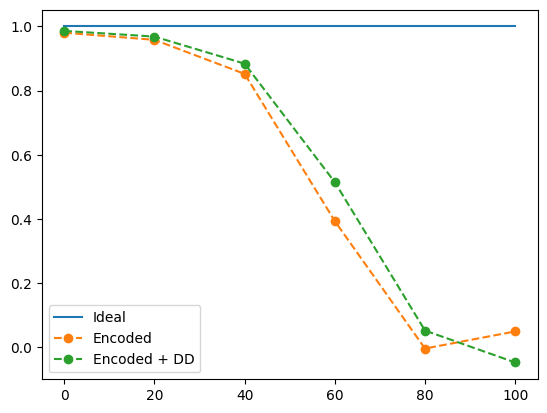

In [73]:
import matplotlib.pyplot as plt

plt.plot(depths, [1.0]*len(depths), label="Ideal")
plt.plot(depths, evals, "--o", label="Encoded")
plt.plot(depths, evals_dd, "--o", label="Encoded + DD")

plt.legend();

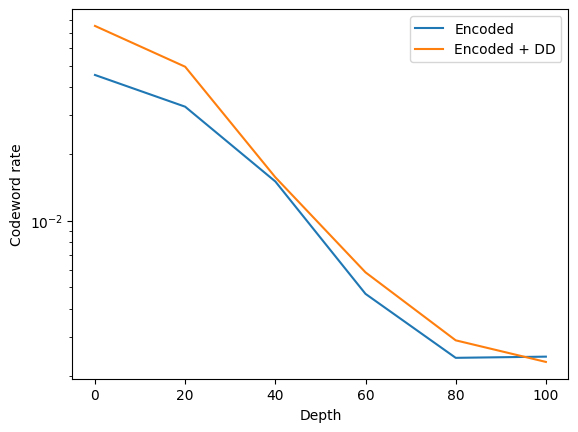

In [87]:
plt.semilogy(depths, ncodewords / nshots, label="Encoded")
plt.semilogy(depths, ncodewords_dd / nshots, label="Encoded + DD")

plt.xlabel("Depth")
plt.ylabel("Codeword rate")

plt.legend();

## Save results

In [106]:
for i, (j, counts_to_save, evals_to_save) in enumerate(zip([job, job_dd], [all_counts, all_counts_dd], [evals, evals_dd])):
    dir = j.job_id() + time_key
    if i == 1:
        dir += "_dd"
    os.mkdir(dir)

    for depth, counts in zip(depths, counts_to_save):
        with open(f"{dir}/depth_{depth}_counts.pkl", "wb") as f:
            pickle.dump(counts, f)

    with open(f"{dir}/nshots.txt", "w") as f:
        f.write(str(nshots))
    
    with open(f"{dir}/computer.txt", "w") as f:
        f.write(computer.name)

    np.savetxt(f"{dir}/evals.txt", evals_to_save)
    np.savetxt(f"{dir}/physical_qubits.txt", layout[distance])
    np.savetxt(f"{dir}/depths.txt", depths)